In [130]:
#code to analyze Allen Brain Atlas
#read csv file from
#Need abagen using niwrap3912
#some tutorials from https://github.com/VinceBaz/hiball_winter_school_2023/blob/main/tutorial.py
import numpy as np
import abagen
# Plot results
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable
import nibabel as nib
from brainspace.utils.parcellation import map_to_labels
import numpy as np
import yaspy
from scipy.stats import zscore


#base_dir = '/Users/dennis.jungchildmind.org/Downloads/normalized_microarray_donor9861'
atlas_path = '/Users/dennis.jungchildmind.org/Downloads/Schaefer2018_400Parcels_17Networks_order_FSLMNI152_1mm.nii.gz'

#array_data = pd.read_csv(os.path.join(base_dir,'MicroarrayExpression.csv')) # The first column is the probe ID. probes by samples
#probe_data = pd.read_csv(os.path.join(base_dir,'Probes.csv')) #probes by genes
#annot_data = pd.read_csv(os.path.join(base_dir,'SampleAnnot.csv')) #mni_x, mni_y, mni_z

In [131]:


def plot_surface_gene_expression(atlas, surf, target_exp_data, gene_names, hemi, vmin=0, vmax=1, cmap='hot'):
    """
    Plot surface gene expression for multiple genes
    
    Parameters:
    -----------
    atlas : array
        Atlas parcellation data
    surf : str
        Path to surface file for specified hemisphere
    target_exp_data : array
        Gene expression data matrix (400 x n_genes)
    gene_names : list
        List of gene names to use as plot titles
    hemi : str
        Hemisphere to plot ('lh' or 'rh')
    """
    # Process hemispheres
    if hemi == 'lh':
        mask = atlas[:32492] != 0
    elif hemi == 'rh':
        mask = atlas[32492:] != 0
    
    # Handle single gene case
    if isinstance(gene_names, str):
        gene_names = [gene_names]
        # Reshape target_exp_data into a 2D array with a single column
        # This ensures the data has shape (n_samples, 1) for single gene case
        target_exp_data = target_exp_data.reshape(-1, 1)
    elif isinstance(gene_names, (list, tuple)):
        # For multiple genes, ensure target_exp_data is 2D
        if len(target_exp_data.shape) == 1:
            target_exp_data = target_exp_data.reshape(-1, 1)
    
    print('target_exp_data shape: ',target_exp_data.shape)
    
    n_genes = target_exp_data.shape[1]

    
        
        
    #
    print('number of genes: ',n_genes)
    # Create figure and axes
    f, axes = plt.subplots(2, n_genes, figsize=(3*n_genes,6))
    
    # Handle single gene case for axes
    if n_genes == 1:
        axes = axes.reshape(-1, 1)
 
    
    for gene_idx in range(n_genes):
        gene_data = target_exp_data[:, gene_idx].reshape(-1, 1)
      
        # Map gene expression to surface
        if hemi == 'lh':
            gene_surf = map_to_labels(gene_data[0:int(max(atlas)/2)].T, atlas[:32492], 
                              mask=mask, fill=np.nan, source_lab=np.arange(1,int(max(atlas)/2)+1))[0]#201))[0]
        else:
            gene_surf = map_to_labels(gene_data[int(max(atlas)/2):].T, atlas[32492:], 
                              mask=mask, fill=np.nan, source_lab=np.arange(int(max(atlas)/2),int(max(atlas))+1))[0]
        
        # Lateral view
        plotter = yaspy.Plotter(surf, hemi=hemi)
        plotter.overlay(gene_surf.T, cmap=cmap, alpha=1, vmin=vmin, vmax=vmax)
        plotter.border(gene_surf.T, alpha=0)
        img_lateral = plotter.screenshot('lateral')
        
        im1 = axes[0, gene_idx].imshow(img_lateral, cmap=cmap)
        axes[0, gene_idx].axis('off')
        axes[0, gene_idx].set_title(gene_names[gene_idx], fontsize=16, fontweight='bold')
        
        # Medial view  
        plotter = yaspy.Plotter(surf, hemi=hemi)
        plotter.overlay(gene_surf.T, cmap=cmap, alpha=1, vmin=vmin, vmax=vmax)
        plotter.border(gene_surf.T, alpha=0)
        img_medial = plotter.screenshot('medial')
        
        im2 = axes[1, gene_idx].imshow(img_medial, cmap=cmap)
        axes[1, gene_idx].axis('off')

        # Add colorbar between the plots
        divider = make_axes_locatable(axes[1, gene_idx])
        cax = divider.append_axes("bottom", size="5%", pad=0.1)
        norm = plt.Normalize(vmin=vmin, vmax=vmax)
        im2.set_norm(norm)
        cbar = plt.colorbar(im2, cax=cax, orientation='horizontal', cmap=cmap)
        cbar.ax.tick_params(labelsize=15)
        
    plt.tight_layout()
    plt.show()

# Load data
atlas = nib.load('/Users/dennis.jungchildmind.org/Downloads/Schaefer2018_400Parcels_17Networks_order.dlabel.nii').get_fdata()[0].astype(int)
lh_surf = '/Users/dennis.jungchildmind.org/Downloads/HCP_S1200_Atlas_Z4_pkXDZ/S1200.L.white_MSMAll.32k_fs_LR.surf.gii'
rh_surf = '/Users/dennis.jungchildmind.org/Downloads/HCP_S1200_Atlas_Z4_pkXDZ/S1200.R.white_MSMAll.32k_fs_LR.surf.gii'
#atlas

pixdim[1,2,3] should be non-zero; setting 0 dims to 1


In [132]:

#https://abagen.readthedocs.io/en/stable/user_guide/expression.html
#Mirrors samples across hemispheres to increase spatial coverage. This does not occur by default; refer to parameter lr_mirror for more info (or see Duplicating samples with the lr_mirror parameter).
expression = abagen.get_expression_data(atlas_path,lr_mirror=True,return_donors = True)#by defaults grabs all donor data and 


In [ ]:



def get_gene_expression(expression, target_gene,do_zscore=True):
    """Get z-scored gene expression values across all donors for a target gene.
    
    Args:
        expression: Dictionary mapping donor IDs to expression DataFrames
        target_gene: Name of gene to extract expression for
        
    Returns:
        Array of z-scored expression values concatenated across donors
    """
    all_exp_data = []
    
    for donor, donor_data in expression.items():
        # Find columns containing target gene
        matching_cols = donor_data.columns[donor_data.columns==target_gene]
        
        if matching_cols.size > 0:
            # Extract and z-score expression values
            exp_values = donor_data[matching_cols].values
            if do_zscore:   
                exp_values = zscore(exp_values, axis=0, nan_policy='omit')
            all_exp_data.append(exp_values)

    return np.concatenate(all_exp_data, axis=1)


pvalb_exp_data = get_gene_expression(expression, 'PVALB')
sst_exp_data = get_gene_expression(expression, 'SST')
vip_exp_data = get_gene_expression(expression, 'VIP')

#save the expression data
np.save('pvalb_exp_data.npy', pvalb_exp_data)
np.save('sst_exp_data.npy', sst_exp_data)
np.save('vip_exp_data.npy', vip_exp_data)

LAYER_GENES = ['NDNF','RASGRF2','CUX2','RORB','TRIB2','B3GALT2','NTNG2','TLE4','CTGF']#c4orf31 is NDNF
for gene in LAYER_GENES:
    exp_data = get_gene_expression(expression, gene)
    np.save(f'{gene.lower()}_exp_data.npy', exp_data)

HSE_GENES = ['BEND5','C1QL2','CACNA1E','COL24A1','COL6A1','CRYM','KCNC3',
             'KCNH4','LGALS1','MFGE8','NEFH','SCN3B','SCN4B',
             'SNCG','SV2C','SYT2','TPBG','VAMP1']

#for gene in HSE_GENES:
#load the expression data
#pvalb_exp_data = np.load('pvalb_exp_data.npy')
#sst_exp_data = np.load('sst_exp_data.npy')
#vip_exp_data = np.load('vip_exp_data.npy')

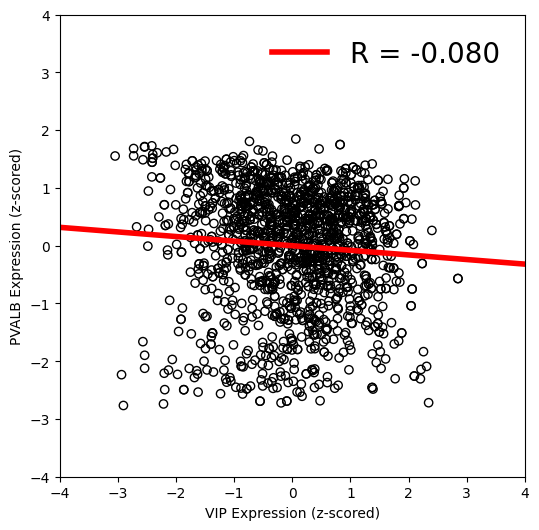

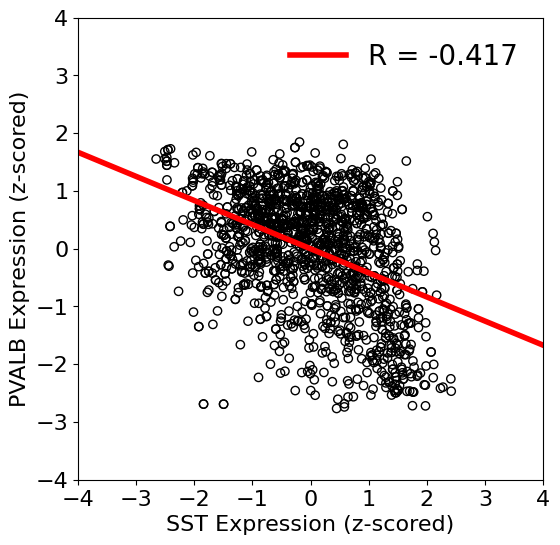

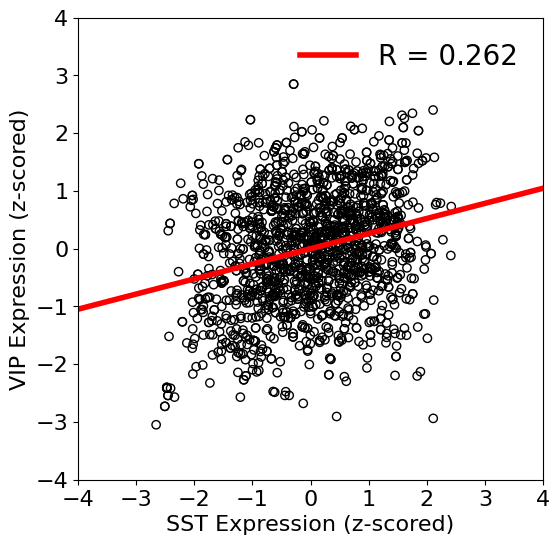

In [ ]:
#function to plot gene correlation
from scipy import stats

def plot_gene_correlation(x_dat, y_dat, xlabel='Gene Expression (z-scored)', ylabel='Gene Expression (z-scored)'):
    
    """Plot correlation between two gene expression datasets with regression line.
    
    Args:
        x_dat: Array of expression values for x-axis
        y_dat: Array of expression values for y-axis 
        xlabel: Label for x-axis
        ylabel: Label for y-axis
    """
   
    plt.scatter(x_dat, y_dat, 
               facecolors='none', 
               edgecolors='black', 
               alpha=1)
    
    plt.rcParams.update({'font.size': 16})
    plt.xticks(np.arange(-5, 5, 1))
    plt.yticks(np.arange(-5, 5, 1))
        
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.ylim(-4, 4)
    plt.xlim(-4, 4)

    # Calculate and plot regression line
    mask = ~np.isnan(x_dat) & ~np.isnan(y_dat)
    slope, intercept, r_value, p_value, std_err = stats.linregress(x_dat[mask], y_dat[mask])
    x = np.linspace(-5, 5, 100)
    plt.plot(x, slope*x + intercept, 
             color='red', 
             label=f'R = {r_value:.3f}',
             linewidth=4)

    plt.legend(frameon=False, fontsize=20)
    #plt.show()

# Call function with current data
# Create scatter plot comparing SST and PVALB expression
x_dat = vip_exp_data
y_dat = pvalb_exp_data
plt.figure(figsize=(6,6))
plot_gene_correlation(x_dat, y_dat, xlabel='VIP Expression (z-scored)', ylabel='PVALB Expression (z-scored)')

x_dat = sst_exp_data
y_dat = pvalb_exp_data
plt.figure(figsize=(6,6))
plot_gene_correlation(x_dat, y_dat, xlabel='SST Expression (z-scored)', ylabel='PVALB Expression (z-scored)')

x_dat = sst_exp_data
y_dat = vip_exp_data
plt.figure(figsize=(6,6))
plot_gene_correlation(x_dat, y_dat, xlabel='SST Expression (z-scored)', ylabel='VIP Expression (z-scored)')

In [123]:
print(vip_exp_data.shape)

(400, 6)


In [ ]:
p

In [128]:
INTERNEURON_MARKER_GENES = ['PVALB','SST','VIP']
#HSE_GENES = ['BEND5','C1QL2','CACNA1E','COL24A1','COL6A1','CRYM','KCNC3',
             #'KCNH4','LGALS1','MFGE8','NEFH','PRSS12','SCN3B','SCN4B',
            # 'SNCG','SV2C','SYT2','TPBG','VAMP1']
            
#somehow the API doesn't return PRSS12
HSE_GENES = ['BEND5','C1QL2','CACNA1E','COL24A1','COL6A1','CRYM','KCNC3',
             'KCNH4','LGALS1','MFGE8','NEFH','SCN3B','SCN4B',
             'SNCG','SV2C','SYT2','TPBG','VAMP1']

#layer specific (PFC),https://www.nature.com/articles/s41586-025-09010-1/figures/3
LAYER_GENES = ['CBLN2','RORB','ETV1','FOXP2','TLE4']

#layer specific (V2),https://www.nature.com/articles/s41586-025-09010-1/figures/3
LAYER_GENES = ['TMOD1','RORB','ETV1','FOXP2','TLE4']

#zeng et al., 2012
LAYER_GENES = ['NDNF','RASGRF2','CUX2','RORB','TRIB2','B3GALT2','NTNG2','TLE4','CTGF']#c4orf31 is NDNF

#Shank3
LAYER_GENES = ['SHANK3']


In [109]:
# Calculate correlation plot for expression data from HSE genes
all_exp_data = []
ALL_GENES = list(expression['9861'].columns);
for i,gene in enumerate(ALL_GENES):
    #show progress bar in percentage and overwrite
    percentage = ((i+1)/len(ALL_GENES))*100
    print(f"\rProcessing {percentage:.1f}%", end="", flush=True)
    if i%100 == 0:
        print(f"\rProcessing {percentage:.1f}%", end="", flush=True)
    exp_data = get_gene_expression(expression, gene,do_zscore=False)
    all_exp_data.append(exp_data)

all_exp_data = np.array(all_exp_data)  # Shape: (18 genes, 400 voxels, 6 samples)



Processing 100.0%

(9, 400, 6)
(9, 400, 6)


/var/folders/71/4g31r9017kq32wt_mx1khjdm0000gn/T/ipykernel_37142/3432659492.py:9: RuntimeWarning: All-NaN slice encountered
  z_int_exp_data_m = np.nanmedian(z_int_exp_data, axis=-1)


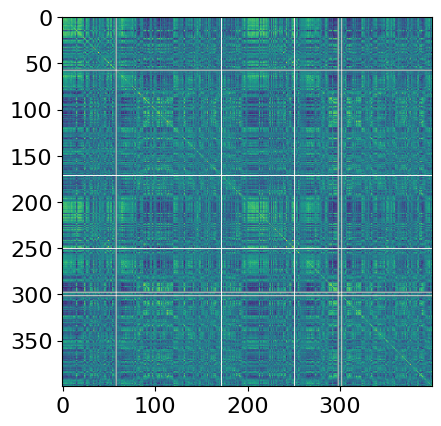

In [ ]:
import numpy as np
from scipy.stats import zscore

print(int_exp_data.shape)
# Z-score along axis 0 first, then axis 1
z_int_exp_data = zscore(int_exp_data, axis=0, nan_policy='omit')
z_int_exp_data = zscore(z_int_exp_data, axis=1, nan_policy='omit')
print(z_int_exp_data.shape)
z_int_exp_data_m = np.nanmedian(z_int_exp_data, axis=-1)
cov_matrix = np.cov(z_int_exp_data_m.T)

plt.imshow(cov_matrix)




[8589, 10859, 3040, 11271, 13967, 1118, 9027, 13469, 2986]
(9, 400, 6)


/var/folders/71/4g31r9017kq32wt_mx1khjdm0000gn/T/ipykernel_37142/1172294610.py:10: RuntimeWarning: All-NaN slice encountered
  int_exp_data_m = np.nanmedian(int_exp_data,axis=-1)


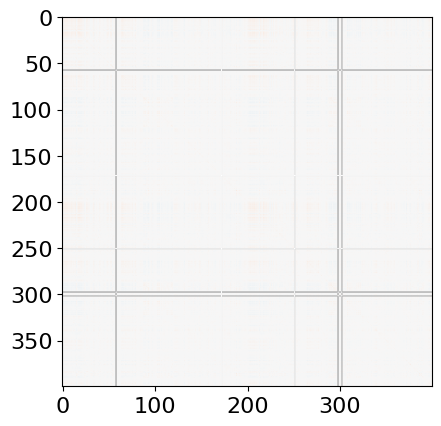

In [ ]:
#find genes INTERNEURON_MARKER_GENES 
INTERNEURON_MARKER_GENES = LAYER_GENES

#find gene index from INTERNEURON_MARKER_GENES from ALL_GENES
INTERNEURON_MARKER_GENES_INDEX = [ALL_GENES.index(gene) for gene in INTERNEURON_MARKER_GENES]
print(INTERNEURON_MARKER_GENES_INDEX)

int_exp_data = all_exp_data[INTERNEURON_MARKER_GENES_INDEX,:]
print(int_exp_data.shape)
int_exp_data_m = np.nanmedian(int_exp_data,axis=-1)
cov_matrix = np.cov(int_exp_data_m.T)
plt.imshow(cov_matrix,cmap='RdBu_r',vmin=-1,vmax=1)

In [ ]:
all_exp_data_m = np.nanmedian(all_exp_data, axis=-1)
print(all_exp_data_m.shape)
cov_matrix = np.cov(all_exp_data_m.T)

(15633, 400)


/var/folders/71/4g31r9017kq32wt_mx1khjdm0000gn/T/ipykernel_37142/416577160.py:1: RuntimeWarning: All-NaN slice encountered
  all_exp_data_m = np.nanmedian(all_exp_data, axis=-1)


(400, 10)
-0.14335824660762606 0.16828832375244196
target_exp_data shape:  (400, 10)
number of genes:  10


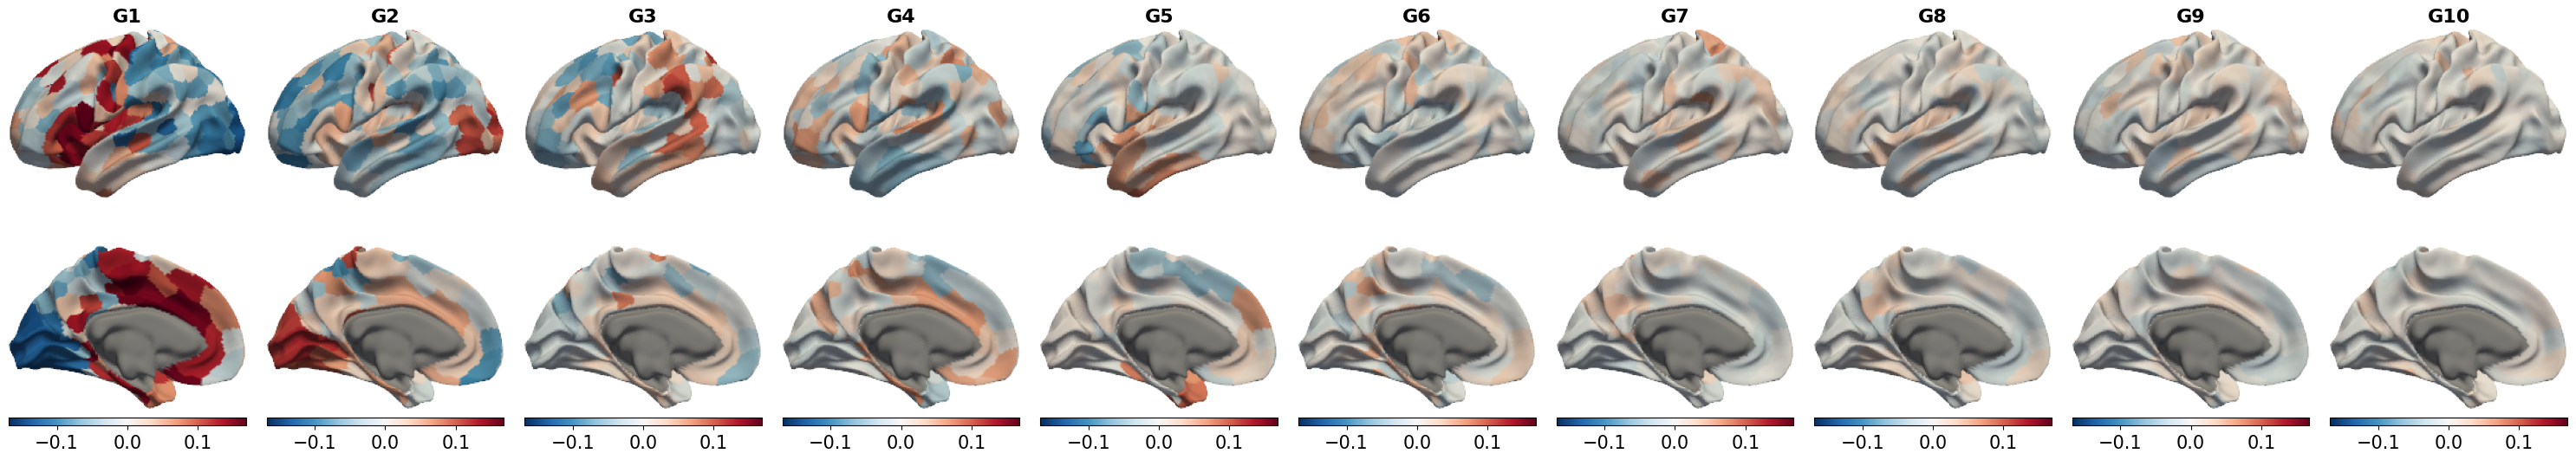

(400, 10)


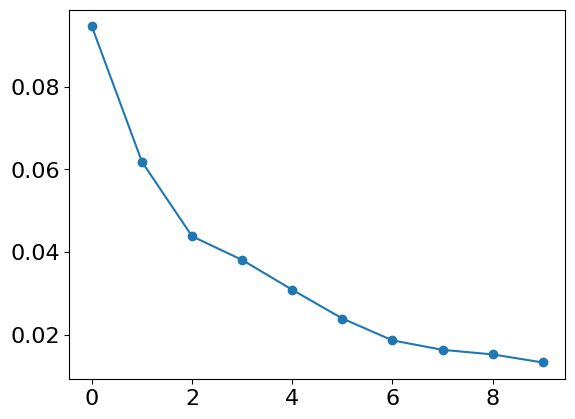

In [ ]:
from brainspace.gradient import GradientMaps
from brainspace.utils.parcellation import map_to_labels

# Print where NaN values are in the covariance matrix
# Create gradient map
gradient_map = GradientMaps(n_components=10, random_state=42,approach='dm', kernel='normalized_angle')
gradient_map.fit(np.nan_to_num(cov_matrix,0))

# Get gradient values
gradient_values = gradient_map.gradients_

# Plot gradient values
print(gradient_values.shape)
vmin = np.nanmin(gradient_values)
vmax = np.nanmax(gradient_values)
#find max of vmin and vmax
print(vmin,vmax)
m=max(abs(vmin),abs(vmax))
plot_surface_gene_expression(atlas, lh_surf, gradient_values,[f'G{i}' for i in range(1,gradient_values.shape[0]+1)], hemi='lh',vmin=-m,vmax=m,cmap = 'RdBu_r')
print(gradient_values.shape)
plt.plot(gradient_map.lambdas_,'-o')


   gradient    gene_0    gene_1    gene_2    gene_3    gene_4    gene_5  \
0 -0.132812  0.071936 -0.871099  1.136565  1.130061 -0.132588 -0.512022   
1 -0.104435 -0.109505 -0.447136  0.794084  0.874102  0.039132 -0.584334   
2 -0.080368 -0.036042  0.034233  0.580929  0.779866  0.321168 -0.414110   
3 -0.060706 -0.016569  0.196166  0.426924  0.508745  0.501514 -0.267656   
4 -0.031296  0.082079  0.309744  0.298018  0.187468  0.091759 -0.055582   
5  0.002548 -0.116785  0.495808  0.014430  0.067187  0.093049  0.092169   
6  0.041030 -0.081939  0.567133 -0.335314 -0.133321 -0.205415  0.169347   
7  0.086433 -0.236781  0.306944 -0.547682 -0.604979 -0.224766  0.301592   
8  0.125773 -0.130142  0.032604 -0.717116 -0.846636 -0.064845  0.597508   
9  0.154336  0.117660 -0.331471 -1.005504 -1.229415  0.127631  0.608173   

     gene_6    gene_7    gene_8  
0 -0.976141  0.269324 -0.558934  
1 -0.614844  0.087251 -0.332341  
2 -0.448339 -0.269571 -0.646961  
3 -0.369711 -0.345205 -0.750460  
4 -0

/var/folders/71/4g31r9017kq32wt_mx1khjdm0000gn/T/ipykernel_37142/1716111966.py:24: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  colors = plt.cm.get_cmap('viridis', NUMBER_OF_BINS).colors


Text(0, 0.5, 'Gradient Value')

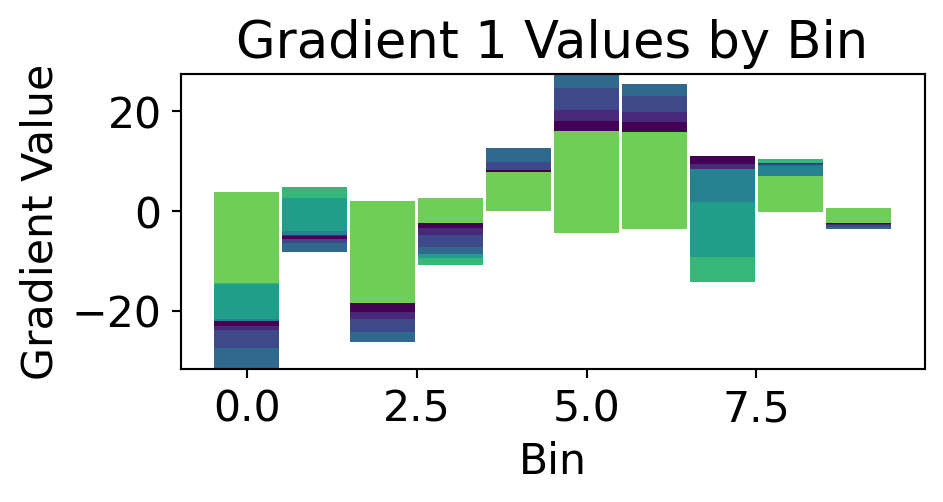

In [122]:
import pandas as pd
GRADIENT_INDEX = 0
NUMBER_OF_BINS = 10
gradient1 = gradient_values[:,GRADIENT_INDEX]  # Get as 1D array instead of DataFrame
#number of bins 
binned_parcels = pd.DataFrame({'gradient': gradient1})
for k in range(z_int_exp_data_m.shape[0]):
    gene_name = f'gene_{k}'
    binned_parcels[gene_name] = z_int_exp_data_m[k,:]
binned_parcels['bin'] = pd.qcut(gradient1, NUMBER_OF_BINS)
# calculate average gradient value at each bin
bins_gradient = binned_parcels.groupby('bin').mean().reset_index(drop=True)
print(bins_gradient)
# reverse the bins so that in the plot the highest bin is at the bottom
bins_gradient = bins_gradient[bins_gradient.columns[::-1]]
#do the relativeafte
# Normalize each bin's values to sum to 1
bins_gradient = bins_gradient.divide(bins_gradient.sum(axis=1), axis=0)

# Create figure and axis
fig, ax = plt.subplots(figsize=(5,2), dpi=192)

# Specify colors using a colormap
colors = plt.cm.get_cmap('viridis', NUMBER_OF_BINS).colors

# Plot stacked bars
ax.bar(
    x = bins_gradient.index,
    height = bins_gradient.iloc[-1],
    width = 0.95,
    color=colors[-1]
)

for bin_num in range(NUMBER_OF_BINS-2, -1, -1):
    ax.bar(
        x = bins_gradient.index,
        height = bins_gradient.iloc[bin_num],
        width = 0.95,
        bottom = bins_gradient.iloc[bin_num+1:].sum(),
        color=colors[bin_num]
    )

ax.set_title(f'Gradient {GRADIENT_INDEX+1} Values by Bin')
ax.set_xlabel('Bin')
ax.set_ylabel('Gradient Value')


In [33]:
print(gradient1_means.columns)


['Layer 1', 'Layer 2', 'Layer 3', 'Layer 4', 'Layer 5', 'Layer 6', 'Layer 7', 'Layer 8', 'Layer 9', 'Layer 10']


In [ ]:

# Calculate correlation matrix handling NaN values
corr_matrix = np.zeros((len(ALL_GENES), len(ALL_GENES)))
for i in range(len(ALL_GENES)):
    for j in range(len(ALL_GENES)):
        mask = ~np.isnan(all_exp_data[i]) & ~np.isnan(all_exp_data[j])
        if np.sum(mask) > 0:
            corr_matrix[i,j] = np.corrcoef(all_exp_data[i][mask], all_exp_data[j][mask])[0,1]
        else:
            corr_matrix[i,j] = np.nan


plt.xticks(range(len(HSE_GENES)), HSE_GENES, rotation=45, ha='right')
plt.yticks(range(len(HSE_GENES)), HSE_GENES)
plt.title('Gene Expression Correlations')
plt.tight_layout()


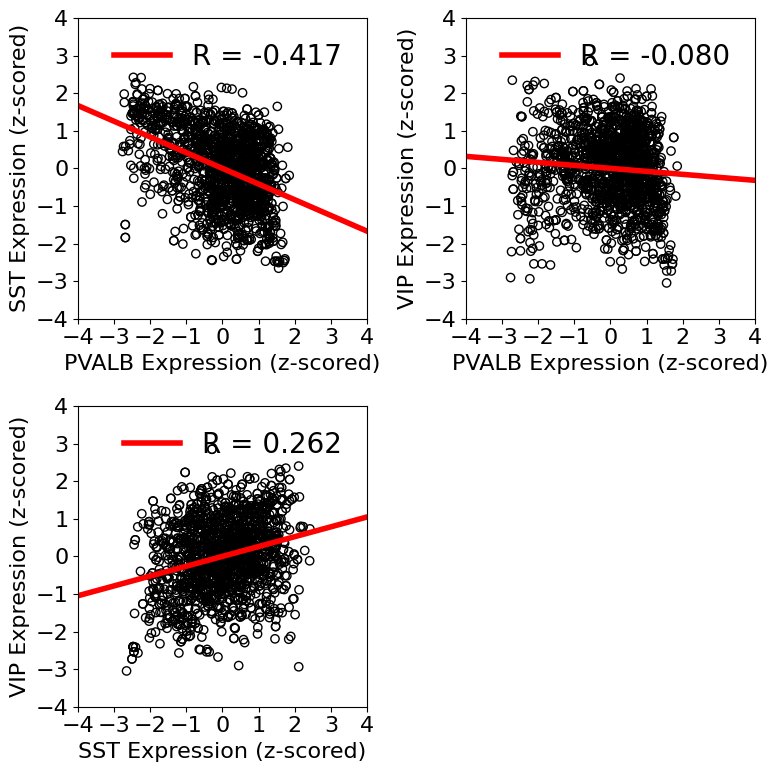

In [ ]:
from itertools import combinations

# Get all unique combinations of HSE genes
gene_combinations = list(combinations(range(len(INTERNEURON_MARKER_GENES)), 2))

# Calculate number of rows and columns for subplot grid
n_plots = len(gene_combinations)
n_cols = int(np.ceil(np.sqrt(n_plots)))
n_rows = int(np.ceil(n_plots / n_cols))

# Make each subplot 4x4 inches
subplot_size = 4
plt.figure(figsize=(subplot_size * n_cols, subplot_size * n_rows))

for idx, (i, j) in enumerate(gene_combinations, 1):
    gene1 = INTERNEURON_MARKER_GENES   [i]
    gene2 = INTERNEURON_MARKER_GENES[j]
    
    exp_data = get_gene_expression(expression, gene1)
    exp_data2 = get_gene_expression(expression, gene2)
    
    plt.subplot(n_rows, n_cols, idx)
    plot_gene_correlation(exp_data, exp_data2, 
                         xlabel=f'{gene1} Expression (z-scored)', 
                         ylabel=f'{gene2} Expression (z-scored)')
plt.tight_layout()
plt.show()

pixdim[1,2,3] should be non-zero; setting 0 dims to 1


target_exp_data shape:  (2400, 1)
number of genes:  1


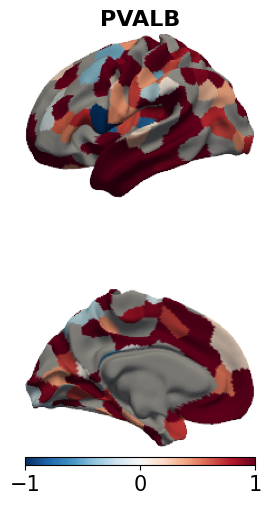

In [ ]:
#plotting single gene expression (zscored, from the get_gene_expression function)
gene_name = 'PVALB'
gene_exp_data = get_gene_expression(expression, gene_name)

plot_surface_gene_expression(atlas, lh_surf, gene_exp_data,gene_name, hemi='lh',vmin=-1,vmax=1,cmap = 'RdBu_r')


(400,)
target_exp_data shape:  (400, 1)
number of genes:  1


/var/folders/71/4g31r9017kq32wt_mx1khjdm0000gn/T/ipykernel_22475/4056355348.py:5: RuntimeWarning: All-NaN slice encountered
  diff = np.nanmedian(exp_data_2 - exp_data_1,axis=1)


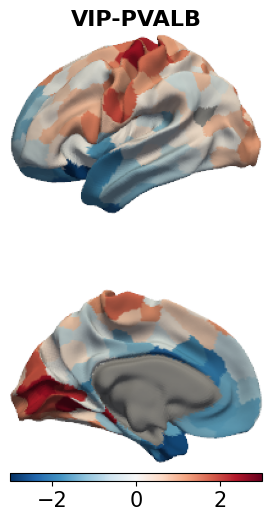

In [60]:
gene1 = 'VIP'
gene2 = 'PVALB'
exp_data_1= get_gene_expression(expression, gene1)
exp_data_2 = get_gene_expression(expression, gene2)
diff = np.nanmedian(exp_data_2 - exp_data_1,axis=1)
print(diff.shape)
plot_surface_gene_expression(atlas, lh_surf, diff,f'{gene1}-{gene2}', hemi='lh',vmin=-3,vmax=3,cmap = 'RdBu_r')
